# Tiền xử lí dữ liệu

## Giới thiệu

Notebook này bao gồm các bước tiền xử lý dữ liệu để chuẩn bị cho việc phân tích và xây dựng mô hình dự đoán cho dự án.

## Mục tiêu

- Đánh giá, xác định hướng xử lý cho các ô/ cột dữ liệu bị thiếu thông tin
- Điền các thông tin bị khuyết
- Feature enginering
- Gom các bảng dữ liệu 
- Chuẩn hóa dữ liệu cho mô hình
- Lọc/ xử lý outliner 

### Import thư viện cần thiết

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import missingno as msno

### Load datasets

In [3]:
df_chotot = pd.read_csv("../datasets/raw_chotot_car_features.csv")
df_bonbanh = pd.read_csv("../datasets/raw_bonbanh_car_features.csv")

### I. Đánh giá dữ liệu thô
#### Chotot

In [4]:
df_chotot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                4928 non-null   object 
 1   price                4928 non-null   object 
 2   Số Km đã đi          4715 non-null   float64
 3   Còn hạn đăng kiểm    2056 non-null   object 
 4   Xuất xứ              4928 non-null   object 
 5   Tình trạng           4928 non-null   object 
 6   Chính sách bảo hành  4928 non-null   object 
 7   Hãng                 4928 non-null   object 
 8   Dòng xe              4928 non-null   object 
 9   Năm sản xuất         4928 non-null   object 
 10  Hộp số               4928 non-null   object 
 11  Nhiên liệu           4928 non-null   object 
 12  Kiểu dáng            4088 non-null   object 
 13  Số chỗ               4380 non-null   object 
 14  Trọng lượng          4715 non-null   object 
 15  Trọng tải            4715 non-null   o

- Dataset có 4928 samples, 21 features, tuy nhiên có nhiều cột đang sai định dạng
- Cần chuyển các cột về đúng định dạng `numerical/categorial`

In [5]:
df_chotot.head()

,title,price,Số Km đã đi,Còn hạn đăng kiểm,Xuất xứ,Tình trạng,Chính sách bảo hành,Hãng,Dòng xe,Năm sản xuất,Hộp số,Nhiên liệu,Kiểu dáng,Số chỗ,Trọng lượng,Trọng tải,location,seller,Số đời chủ,Có phụ kiện đi kèm
0,BMW X5 2007 3.0si - 88000 km,320.000.000 đ,88000.0,Có,Đang cập nhật,Đã sử dụng,Bảo hành hãng,BMW,X5,2007,Tự động,Xăng,SUV / Cross over,8,> 1 tấn,> 2 tấn,"Phường 1, Quận 4, Tp Hồ Chí Minh",NaN,NaN,NaN
1,Mercedes Benz E240 W210 2001,108.000.000 đ,135000.0,Có,Đức,Đã sử dụng,Bảo hành hãng,Mercedes Benz,E Class,2001,Tự động,Xăng,Sedan,5,> 1 tấn,> 2 tấn,"Phường 4, Quận 8, Tp Hồ Chí Minh",NaN,> 1 chủ,Có
2,Ford Transit 2017 Standard - 275000 km,365.000.000 đ,275000.0,Có,Việt Nam,Đã sử dụng,Bảo hành hãng,Ford,Transit,2017,Số sàn,Dầu,Kiểu dáng khác,16,> 1 tấn,> 2 tấn,"Phường Thốt Nốt, Quận Thốt Nốt, Cần Thơ",NaN,1 chủ,Có
3,Chevrolet Cruze 2016 - 60.150 km,339.000.000 đ,60150.0,Có,Mỹ,Đã sử dụng,Bảo hành hãng,Chevrolet,Cruze,2016,Tự động,Xăng,Sedan,5,> 1 tấn,> 2 tấn,"Phường Ba Láng, Quận Cái Răng, Cần Thơ",NaN,> 1 chủ,Không
4,Toyota Camry 2009 LE 2.5 - 15000 km,380.000.000 đ,15000.0,Có,Mỹ,Đã sử dụng,Bảo hành hãng,Toyota,Camry,2009,Tự động,Xăng,Sedan,4,> 1 tấn,> 2 tấn,"Phường Mỹ Đình 1, Quận Nam Từ Liêm, Hà Nội",NaN,1 chủ,NaN


- `title`: Thường chứa hãng/tên xe, năm sản xuất, dung tích, odo (km) - nhưng hầu hết phần này đã được tách ra vào các cột riêng trong dataset. Vì vậy giữ `title` nguyên bản để tham chiếu là đủ; không nên phụ thuộc vào `title` để tạo các trường chính cho mô hình.

- `price`: giá hiện lưu dưới dạng chuỗi với dấu phân nghìn `.` và hậu tố `đ` (ví dụ: `320.000.000 đ`, `123.879.846 đ`). Một số giá có dạng không tròn (thực tế VND), giá có khoảng rộng (từ vài chục triệu tới > 2 tỷ).
  - Xóa dấu `.` và ký tự không số, bỏ hậu tố `đ`, chuyển về số nguyên VND.
  - Kiểm tra ngoại lệ (giá = 0, NULL, hoặc giá quá nhỏ/lớn so với phân phối) và xử lý (loại bỏ hoặc gắn nhãn outlier).

- `Số Km đã đi`: phần lớn là số nguyên (ví dụ `88000`, `275000`), nhưng có vài giá trị bất thường (ví dụ `999999` trong dataset mẫu — có khả năng là placeholder hoặc lỗi). 
  - Chuyển về numeric, thay các giá trị rất lớn (>= 900000) thành `NaN` để đánh dấu outlier/placeholder.

- `Năm sản xuất`: có trong cột riêng; cần chuyển về `int` và kiểm tra phạm vi hợp lệ (ví dụ 1980 ≤ year ≤ current_year + 1). Giá trị ngoài khoảng này nên được gắn `NaN` để xử lý sau.

- `Hộp số`, `Nhiên liệu`, `Kiểu dáng`, `Số chỗ`: là các categorical có vocabulary rõ ràng nhưng không đồng nhất (ví dụ `Tự động` / `Số sàn` / `Bán tự động` / blank). Hành động:
  - Điền missing bằng cách gọi API của `https://www.auto-data.net`.

- `Số đời chủ`: hiện lưu dạng text (`1 chủ`, `> 1 chủ`, hoặc blank). Map sang numeric: `1 chủ` → 1, `> 1 chủ` → 2, blank → `NaN`.

- `Có phụ kiện đi kèm`: giá trị `Có`/`Không`/blank → map thành boolean (True/False) với blank → `NaN` hoặc False (cho rằng không đưa thông tin là không có).

- `location`: thường chứa phường/quận và tỉnh/thành — thông tin có thể rút thành `city`. Tuy nhiên format không đồng nhất; nên parse bằng rule đơn giản (tách theo dấu phẩy và lấy phần cuối làm `city`) và kiểm tra tỷ lệ thành công.

<Axes: >

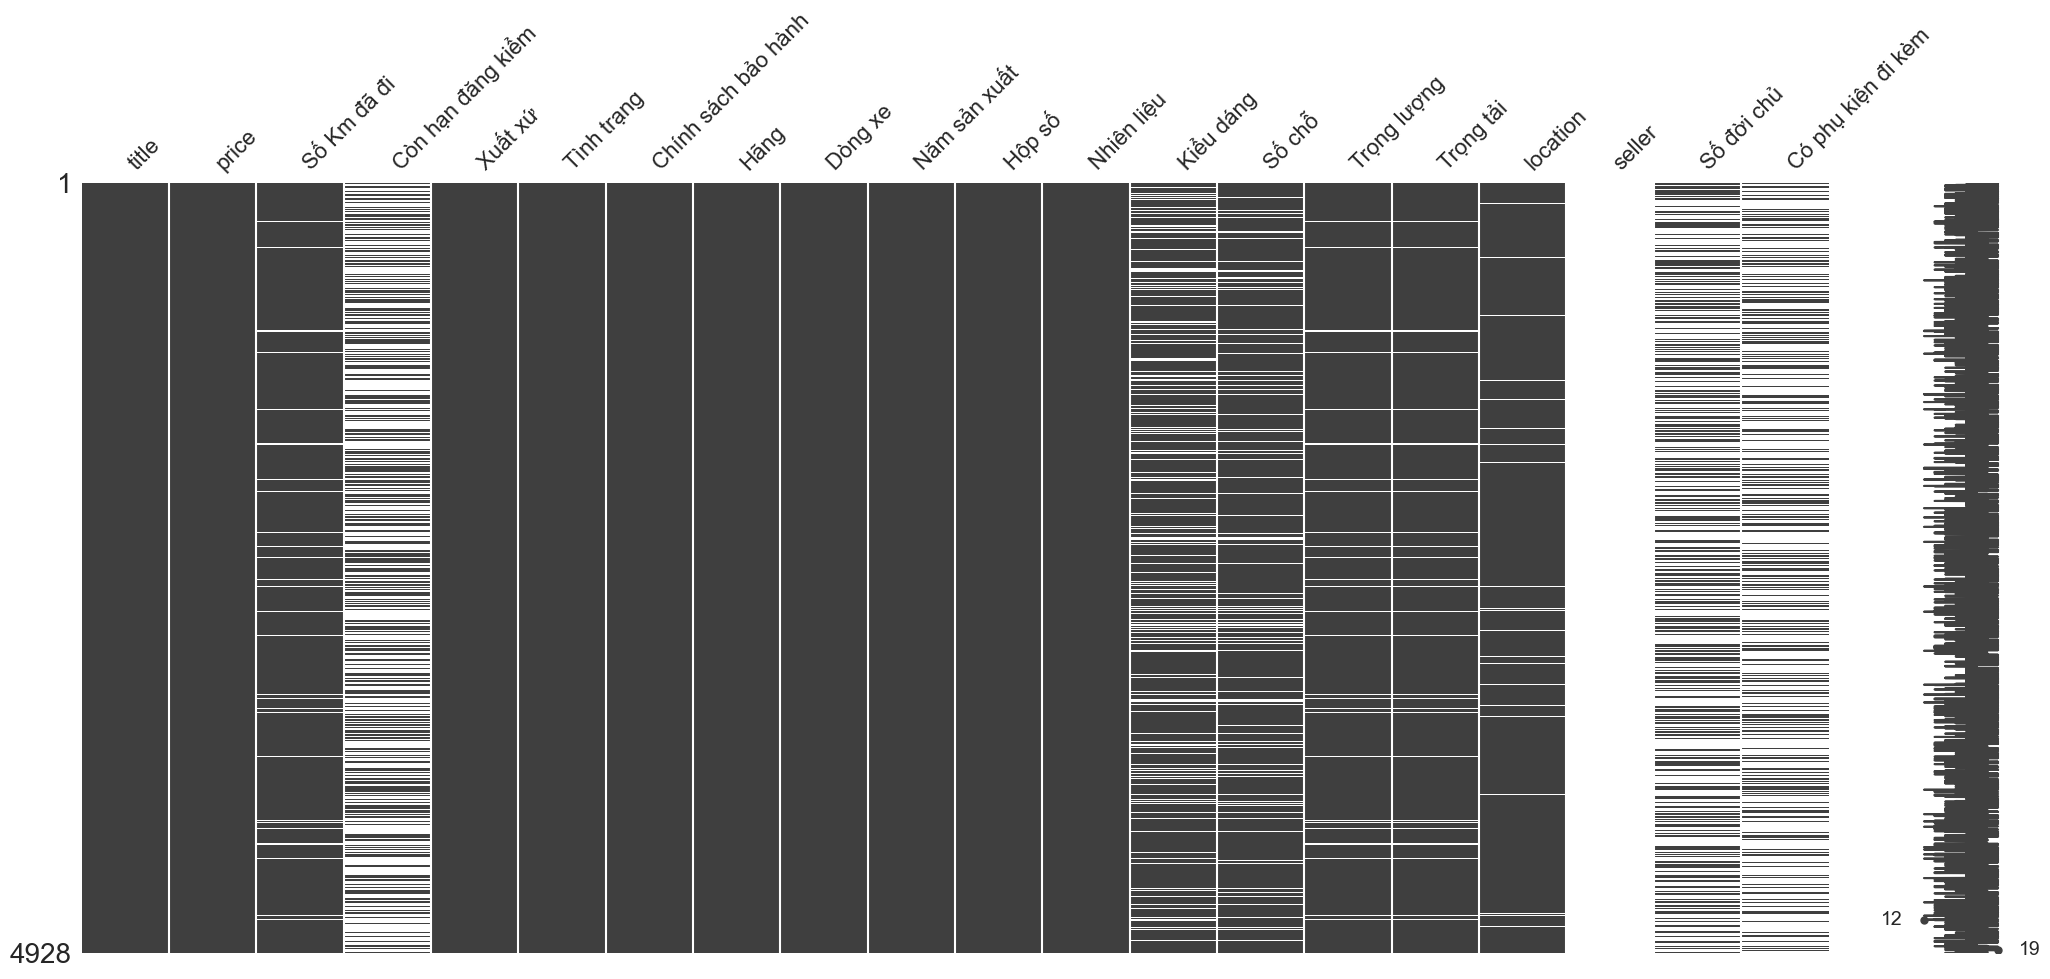

In [6]:
msno.matrix(df_chotot)

In [7]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [8]:
chotot_missing_summary = get_numerical_summary(df_chotot)

Số Km đã đi : 213 (4.322%)
Còn hạn đăng kiểm : 2872 (58.279%)
Kiểu dáng : 840 (17.045%)
Số chỗ : 548 (11.12%)
Trọng lượng : 213 (4.322%)
Trọng tải : 213 (4.322%)
location : 149 (3.024%)
seller : 4928 (100.0%)
Số đời chủ : 2808 (56.981%)
Có phụ kiện đi kèm : 3332 (67.614%)


- `Số Km đã đi` — 213 missing (4.322%): tỷ lệ thấp; xử lý đơn giản bằng cách impute median hoặc mean, hoặc giữ NaN và dùng indicator `km_missing`. Những giá trị placeholder lớn (ví dụ 999999) nên được convert thành NaN trước khi impute.

- `Còn hạn đăng kiểm` — 2872 missing (58.279%): thiếu nhiều; cột này không ổn định để dùng trực tiếp. 

- `Kiểu dáng` — 840 missing (17.045%): tỷ lệ vừa phải — nên cố gắng chuẩn hóa và điền bằng mode hoặc map theo `title` nếu khả thi; nếu không, fill = 'unknown'.

- `Số chỗ` — 548 missing (11.12%): mức vừa phải — impute bằng mode theo `Kiểu dáng`/`Hãng` hoặc fill `'unknown'`.

- `Trọng lượng`, `Trọng tải` — 213 missing mỗi cột (4.322%): tỷ lệ thấp; impute bằng mode hoặc giữ NaN nếu ít quan trọng.

- `location` — 149 missing (3.024%): rất thấp; cố gắng parse `city` hoặc sử dụng model để fill phần còn lại.

- `seller` — 4928 missing (100.0%): hoàn toàn trống trong mẫu — không dùng cột này.

- `Số đời chủ` — 2808 missing (56.981%): thiếu nhiều; cột này không ổn định để dùng trực tiếp. 

- `Có phụ kiện đi kèm` — 3332 missing (67.614%): thiếu nhiều; cột này không ổn định để dùng trực tiếp.

#### BonBanh